In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN


algorithm_globals.random_seed = 42

In [2]:
import os

# Establece la GPU a usar (en este caso la GPU #1)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import pandas as pd
from sklearn.datasets import load_wine

# Load dataset
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target

# Keep only classes 0 and 1
df = df[df['target'].isin([0, 1])]

# Select columns
selected_columns = ['alcohol', 'malic_acid', 'ash', 'target']
df = df[selected_columns]

# Sample 5 samples per class (3 for train, 2 for test)
df_sampled = df.groupby('target').apply(lambda x: x.sample(5, random_state=42)).reset_index(drop=True)

# Split: 3 for train, 2 for test per class
train = df_sampled.groupby('target').head(3).reset_index(drop=True)
test = df_sampled.groupby('target').tail(2).reset_index(drop=True)

X_train = train.drop(columns='target').values
y_train = train['target'].values
X_test = test.drop(columns='target').values
y_test = test['target'].values

num_qubits = 2


/tmp/ipykernel_2049341/4124029957.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('target').apply(lambda x: x.sample(5, random_state=42)).reset_index(drop=True)


In [3]:
from sklearn.datasets import load_wine
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target

# Pick 3 columns (example: 'alcohol', 'malic_acid', 'ash')
selected_columns = ['alcohol', 'malic_acid', 'target']
df = df[selected_columns]

# Get 3 samples per class
df = df.groupby('target').head(3).reset_index(drop=True)

train = df.groupby('target').head(2).reset_index(drop=True)
test = df.groupby('target').tail(1).reset_index(drop=True)

X_train = train.drop(columns='target').values
y_train = train['target'].values
X_test = test.drop(columns='target').values
y_test = test['target'].values

num_qubits = 2


# NeuralNetwork Qiskit instance:
* This class is the interface for all QNNs available in qiskit-machine-learning. This is an abstract class all QNNs inherit from. 
* It provides forward and backward pass and handles batched inputs. 
* It takes data samples and trainable weights as input.
* This class is "stateless". This means that it doesn't contain any training capabilities, nor do they store the training values for trainable weights. This "NeuralNetwork"s are pushed to the actual algorithms or applications (classifiers, regresors...).



## QNN CIRCUIT DEFINITION

We use the QNNCircuit library to build the Quantum Neural Network.

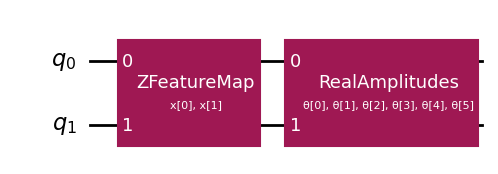

In [ ]:
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.circuit.library import QNNCircuit

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
ansatz = RealAmplitudes(num_qubits, reps=2)
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)
qc.draw("mpl")

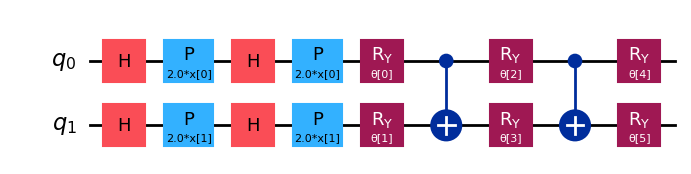

In [6]:
qc.decompose().draw("mpl")

# SamplerQNN
* This is an implementation based on the Sampler qiskit primitive. It takes in an optional instance of its corresponding primitive. 
* It's a Neural Neetwork based on the samples resulting from measuring a quantum circuit. 
* These output samples are interpreted by default as the probabilities of measuring the integer index corresponding to a bitstring.
  * Example: If we measure 00, 01, 10, 11 (in a 2 qubit circuit), that will be interpreted as the integers 0,1,2,3 respectively, and the final result will be a 4 value probability vector (state vector).

* Interpreter: It consists on a function to post-process the samples. It takes an integer (the index from a measured bitstring) and maps it to a new value (Which should be a more significant integer for our problem).
  * Example: Parity function (00, 11 --> 0  and  01, 10 --> 1). In this case, the final result will be a probabillity vector of length 2.

* Output shape: If an interpreter function is used, this parameter must be specified manually. 


In [6]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [16]:
feature_map.parameters

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2])])

In [17]:
objective_func_vals = []
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
from qiskit_ibm_runtime import SamplerV2, Session
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit_machine_learning.gradients import ParamShiftSamplerGradient


backend = AerSimulator(method='statevector', device='GPU')
session = Session(backend=backend)
pass_manager = generate_preset_pass_manager(optimization_level=0, target=backend.target)

sampler = SamplerV2(mode=session)
sampler_gradient = ParamShiftSamplerGradient(sampler=sampler, pass_manager=pass_manager)
isa_qc = pass_manager.run(qc)

sampler_qnn = SamplerQNN(
    circuit=isa_qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sampler=sampler,
    gradient=sampler_gradient,
)

In [8]:
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30)#, callback=callback_graph
)

In [9]:
sampler_classifier.fit(X_train, y_train)

In [10]:
sampler_classifier.score(X_test, y_test)

0.3333333333333333

In [11]:
sampler_classifier.predict(X_test)

array([1, 1, 1])

# TEST

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv("train_QNN3.csv")
test = pd.read_csv("test_QNN3.csv")

# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category'])
y_train = train['category']

# Separar características y etiquetas para conjunto de prueba
X_test = test.drop(columns=['category'])
y_test= test['category']

In [5]:
from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow.keras.utils import to_categorical

#Codificacion de etiquetas (Numéricas)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

# Convertir las etiquetas codificadas a codificación one-hot (10 columnas por muestras)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=10)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=10)

2025-05-02 19:15:09.206437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746213309.228522 2775576 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746213309.235367 2775576 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 19:15:09.257312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from IPython.display import clear_output
objective_func_vals = []
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [6]:
history = []

def vqc_callback(weights, objective_value):
    history.append((weights.copy(), objective_value))


In [7]:
from qiskit_ibm_runtime import SamplerV2, Session
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit_machine_learning.algorithms.classifiers import  VQC
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap

num_qubits = X_train.shape[1]

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
ansatz = RealAmplitudes(num_qubits, reps=2)

backend = AerSimulator(method='statevector', device='GPU')
session = Session(backend=backend)
pass_manager = generate_preset_pass_manager(optimization_level=0, target=backend.target)

sampler = SamplerV2(mode=session)
#sampler_gradient = ParamShiftSamplerGradient(sampler=sampler, pass_manager=pass_manager)

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=50),
    callback=vqc_callback,
    sampler=sampler,
    pass_manager=pass_manager,
    output_shape=10
    #gradient=sampler_gradient,
)

In [ ]:
import time

start_time = time.time()
vqc.fit(X_train, y_train_one_hot)
end_time = time.time()


print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")

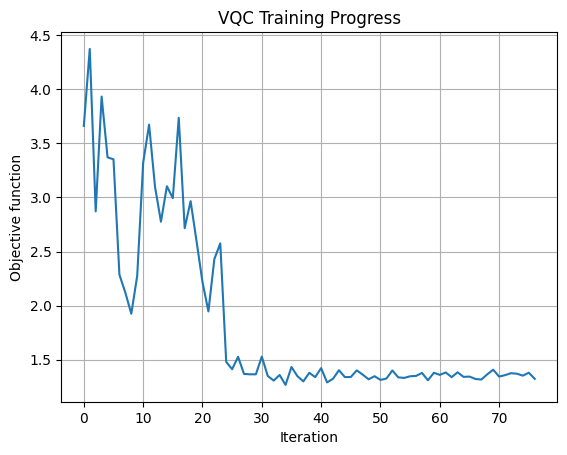

In [14]:
# Por ejemplo, plotear la evolución del loss
import matplotlib.pyplot as plt

losses = [entry[1] for entry in history]
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.title("VQC Training Progress")
plt.grid(True)
plt.show()